LangGraph Playbook

In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import display, Image
import gradio as gr
from pydantic import BaseModel, Field
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from typing import TypedDict

In [2]:
load_dotenv(override=True)

True

In [ ]:
class State(BaseModel):
    message: Annotated[list, add_messages]

graph_bulder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

def chatbot_node(old_state: State) -> State:
    response = llm.invoke(old_state.message)
    return State(message=[response])

graph_bulder.add_node("chatbot", chatbot_node)

graph_bulder.add_edge(START, "chatbot")
graph_bulder.add_edge("chatbot", END)

graph = graph_bulder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# calling the chatbot
def chat(user_input: str, history):
    initial_state = State(message=[user_input])
    result = graph.invoke(initial_state)
    print(result["message"][-1].content)
    return result["message"][-1].content

gr.ChatInterface(chat, type="messages").launch()


In [3]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("What is the weather in Tokyo?")

"Tokyo, Tokyo, Japan Weather Forecast, with current conditions, wind, air quality, and what to expect for the next 3 days. 10 Day Weather-Minato-ku, Tokyo Prefecture, Japan. As of 9:52 pm JST. High Wave Advisory. +1 More. Tonight. --/81°. 4%. Night. 81°. 4%. SSW 11 mph. Scattered clouds. Feels Like: 113 °F. Humidity: 44%. Precipitation: Rain: 0 Snow: 0. Precipitation Chance: 5%. SSE. Wind: 12 ... 6 Aug (Wednesday), 201 Mostly cloudy, 38° ; 7 Aug (Thursday), 113 Clear, frequent scattered showers later, 35° ; 8 Aug (Friday), 203 Cloudy, frequent scattered ... PARTLY CLOUDY. MaximumMinimum, MaximumMinimum, MaximumMinimum. Tokyo36°C-, Tokyo37°C27°C, Tokyo--. Probability of precipitation. 00-06--%. 06-12--%. 12-180%. Day by day forecast · Tonight. ,. Partly cloudy and a gentle breeze · Sunday 3rd AugustSun 3rd. ,. Sunny intervals and a gentle breeze · Monday 4th AugustMon ... Tokyo Weather Forecasts. Weather Underground provides local & long-range weather forecasts, weatherreports, maps & t

In [4]:
from langchain.agents import Tool

tool_search = Tool(
    name="Search",
    description="Search the web for information",
    func=serper.run
)

tool_search.invoke("What is the weather in Tokyo?")

"Tokyo, Tokyo, Japan Weather Forecast, with current conditions, wind, air quality, and what to expect for the next 3 days. 10 Day Weather-Minato-ku, Tokyo Prefecture, Japan. As of 9:52 pm JST. High Wave Advisory. +1 More. Tonight. --/81°. 4%. Night. 81°. 4%. SSW 11 mph. Scattered clouds. Feels Like: 113 °F. Humidity: 44%. Precipitation: Rain: 0 Snow: 0. Precipitation Chance: 5%. SSE. Wind: 12 ... 6 Aug (Wednesday), 201 Mostly cloudy, 38° ; 7 Aug (Thursday), 113 Clear, frequent scattered showers later, 35° ; 8 Aug (Friday), 203 Cloudy, frequent scattered ... PARTLY CLOUDY. MaximumMinimum, MaximumMinimum, MaximumMinimum. Tokyo36°C-, Tokyo37°C27°C, Tokyo--. Probability of precipitation. 00-06--%. 06-12--%. 12-180%. Partly sunny. Feels Like: 91 °F Forecast: 100 / 82 °F Wind: 5 mph ↑ from South. Location: Tokyo. Current Time: Aug ... Day by day forecast · Tonight. ,. Partly cloudy and a gentle breeze · Sunday 3rd AugustSun 3rd. ,. Sunny intervals and a gentle breeze · Monday 4th AugustMon .

In [5]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data={
        "token": pushover_token,
        "user": pushover_user,
        "message": text
    })

In [6]:
tool_push = Tool(
    name="Send_push_notification",
    description="Send a push notification to the user",
    func=push
)

tool_push.invoke("Hello, me")

In [7]:
tools = [tool_search, tool_push]

In [8]:
class State(TypedDict):
    messages:Annotated[list, add_messages]

In [10]:
graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))


In [11]:
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")


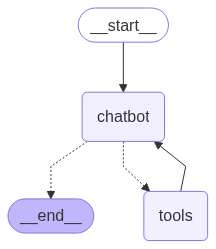

In [13]:
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages", theme="dark" ).launch()

/Users/gulnaratimokhina/Documents/AgenticAIWorkspace/agenticAI/.venv/lib/python3.12/site-packages/gradio/blocks.py:1180: UserWarning: Cannot load dark. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/dark (Request ID: Root=1-6892615c-5077e34444fbd1db5ea7dc23;e3518472-a8f3-4dd5-98b2-d94c966c1507)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


Adding Memory

In [16]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

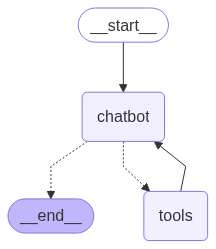

In [17]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# config will add memory to chat
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config = config)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages", theme="dark" ).launch()
    

/Users/gulnaratimokhina/Documents/AgenticAIWorkspace/agenticAI/.venv/lib/python3.12/site-packages/gradio/blocks.py:1180: UserWarning: Cannot load dark. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/dark (Request ID: Root=1-689264fa-7803a22c3b25516308fe89dd;1d611812-bb6b-4200-bce0-3af9cfc492e7)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='f95c6374-6937-4687-a360-d6508f8a5518')]}
{'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='f95c6374-6937-4687-a360-d6508f8a5518'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 80, 'total_tokens': 90, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C1IGoEZQH3tQlYPcXTjn22tr1Gnno', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--ac59bf91-6ea4-4402-9b2e-0120c3f48ec8-0', usage_metadata={'input_tokens': 80, 'output_tokens': 10, 'total_tokens': 90, 'input_tok

In [20]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='f95c6374-6937-4687-a360-d6508f8a5518'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 80, 'total_tokens': 90, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C1IGoEZQH3tQlYPcXTjn22tr1Gnno', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--ac59bf91-6ea4-4402-9b2e-0120c3f48ec8-0', usage_metadata={'input_tokens': 80, 'output_tokens': 10, 'total_tokens': 90, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage

In [21]:
list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='f95c6374-6937-4687-a360-d6508f8a5518'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 80, 'total_tokens': 90, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C1IGoEZQH3tQlYPcXTjn22tr1Gnno', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--ac59bf91-6ea4-4402-9b2e-0120c3f48ec8-0', usage_metadata={'input_tokens': 80, 'output_tokens': 10, 'total_tokens': 90, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessag

Store memory in SQL

In [22]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

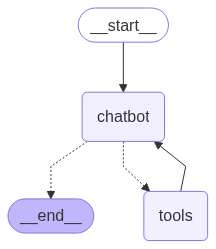

In [23]:
 # Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))
 

In [ ]:
config = {"configurable": {"thread_id": "3"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config = config)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7866
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hello, my name is Gulya', additional_kwargs={}, response_metadata={}, id='6f015f29-a226-42ef-bbe1-66e1726450ab')]}
{'messages': [HumanMessage(content='hello, my name is Gulya', additional_kwargs={}, response_metadata={}, id='6f015f29-a226-42ef-bbe1-66e1726450ab'), AIMessage(content='Hello, Gulya! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 86, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C1KtgJDIIzu2tCzMkZWXhkHJEVRX6', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--20f4175f-cdf4-4c3d-b651-47e405e84390-0', usage_metadata={'input_tokens': 86, 'output_